In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 1e-4
batch_size = 2
wd = 1e-5
# pos_weight = 2
image_size = 256
# backbone="segmentation"
backbone="none"
vertical_type = "axial"
train_portion = 0.5
milestones = [50, 100, 150, 200]
model_name = "effdet"

slice_range=5

In [8]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing
# from sklearn.model_selection import GroupKFold

IMAGE_SIZE = 512


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95')

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv'))
print(len(df))
df.head()

7203


,StudyInstanceUID,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


StudyInstanceUID      1.2.826.0.1.3680043.11901
start_slice_number                            1
axial_index                                 127
coronal_index                               226
sagittal_index                              257
aspect                                 1.670146
pixel_spacing                             0.479
z_spacing                                   0.8
is_flip                                     0.0
num_slices                                  292
x                                     246.82491
y                                       212.992
width                                  21.65923
height                                 26.46275
slice_number                                128
Name: 370, dtype: object
[[246.82491, 212.992, 21.65922999999998, 26.462750000000028]]


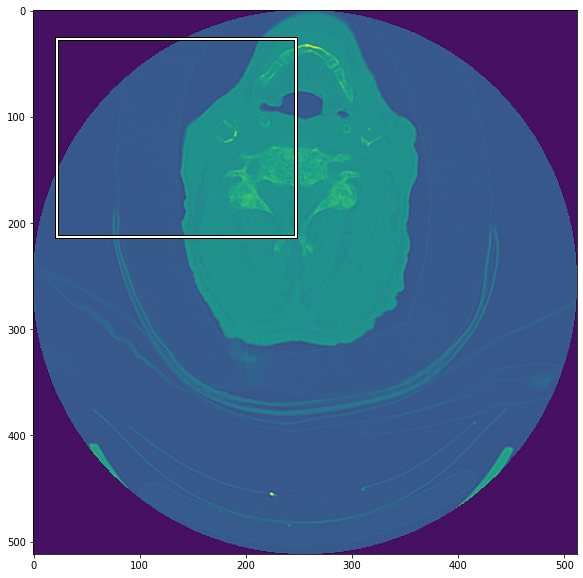

In [21]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    # bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height

def draw_pascal_voc_bboxes(
        plot_ax,
        bboxes,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        # x, y, width, height = get_rectangle_corners_fn(bbox)
        # print(bbox)
        x, y, width, height = bbox


        rect_1 = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
        image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

s = df.iloc[370]
print(s)
image = Image.open(os.path.join(IMAGES_DIR, s.StudyInstanceUID, f'{s.axial_index}.jpeg'))
bboxes = [list(s[['x', 'y','width','height']])]
print(bboxes)
show_image(image, bboxes)

## Dataset Adaptor

In [ ]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, df):
        self.image_dir = images_dir_path
        self.df = df

    def __len__(self) -> int:
        return len(self.df)

    def get_image_and_labels_by_idx(self, idx):
        s = self.df.iloc[idx]
        # img = Image.open(os.path.join(self.images_dir_path, s['StudyInstanceUID'], f"{s['axial_index']}.jpeg"))

        UID = s['StudyInstanceUID']
        slice = s['axial_index']
        r = Image.open(os.path.join(self.image_dir, UID, f"{slice-1}.jpeg"))
        g = Image.open(os.path.join(self.image_dir, UID, f"{slice-0}.jpeg"))
        b = Image.open(os.path.join(self.image_dir, UID, f"{slice+1}.jpeg"))
        img = Image.merge('RGB', (r, g, b))

        pascal_bboxes = [[s.x, s.y, s.x + s.width, s.y + s.height]]
        class_labels = np.ones(1)

        return img, pascal_bboxes, class_labels, idx

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, df)
# da.show_image(2)

Creating the model


## Dataset

In [ ]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        # pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                            :, [1, 0, 3, 2]
                                            ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.]),
            # "img_scale": [1., 1.],
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

train_dataset = EfficientDetDataset(da, transforms=get_train_transforms())
img, ann, idx = train_dataset[0]
print(ann)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img[0, :, :])
# print(ann['bboxes'])
# draw_pascal_voc_bboxes(ax, ann['bboxes'])


In [ ]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    # shuffle=True,
    shuffle=False,
    pin_memory=True,
    drop_last=True,
    # num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

In [ ]:
images, annotations, _, image_ids = next(iter(train_loader))
print(annotations)
print(images.shape)
# print(_)
# print(image_ids)

In [ ]:
from effdet import create_model
model = create_model('tf_efficientdet_lite0' , bench_task='train' , num_classes= 1 , image_size=(IMAGE_SIZE,IMAGE_SIZE),bench_labeler=True,pretrained=True)
model = model.to(device)

In [25]:
images = torch.randn((2, 3, 512, 512)).to(device)
annotations = {
    'bbox' : [torch.randn((2, 4)).to(device), torch.randn((3, 4)).to(device)],
    'cls' : [torch.ones(2).to(device), torch.ones(3).to(device)]
}
print(annotations)
model(images, annotations)

{'bbox': [tensor([[ 0.3011,  1.4055,  0.1306, -0.9147],
        [-0.9309,  1.1566, -0.0894, -0.5522]]), tensor([[-0.3299, -0.7674, -0.3774,  0.4820],
        [ 1.7670,  0.0377, -0.8770, -1.5318],
        [ 0.1933, -0.3323, -0.3887, -0.5790]])], 'cls': [tensor([1., 1.]), tensor([1., 1., 1.])]}


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.